In [257]:
import time 
import pickle

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

import optuna
from xgboost import XGBClassifier, XGBRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize

        
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

In [273]:
# path = 'Data/test.csv'  
# path = 'Data/please.csv' 
path = 'Data/data_with_predictions.csv'
data = pd.read_csv(path)
print(data.shape)

(1944, 14)


In [274]:
# Fill missing RSSI values
data['rssi_ap_digilab'] = data['rssi_ap_digilab'].fillna(-200)
data['rssi_ap_dosen'] = data['rssi_ap_dosen'].fillna(-200)

In [275]:
ap_coordinates = {
    'DTE Staff (Digilab)': (867, 1122),
    'DTE Staff (Dosen)': (2454, 520)
}

In [276]:
# Define a mapping for BSSID and corresponding transmit power
bssid_to_transmit_power = {
    1: 23,  # AP Dosen
    2: 23,  # AP Dosen
    3: 26,  # AP Digilab
    4: 26   # AP Digilab
}

# Add the 'transmit_power' column based on BSSID
# data['transmit_power'] = data['bssid'].map(bssid_to_transmit_power)

data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
718,2024-10-23 02:53:02.765489+00:00,11,16,DTE Staff,1,1,759,1368,-200.0,-94.0,0,02:53:02.765489,759,1366
798,2024-10-23 03:11:25.724209+00:00,13,12,DTE Staff,3,11,759,1749,-75.0,-200.0,0,03:11:25.724209,759,1749
334,2024-10-17 09:57:50.159182+00:00,8,13,DTE Staff,3,11,529,1749,-68.0,-200.0,0,09:57:50.159182,529,1748
12,2024-10-17 08:41:46.015794800+00:00,1,6,DTE Staff,3,11,300,1368,-64.0,-200.0,0,08:41:46.015794,300,1368
617,2024-10-17 10:42:03.462011900+00:00,37,8,DTE Staff,3,11,1908,1037,-56.0,-200.0,1,10:42:03.462011,1908,1038


## Scaling using Robust Scaler


In [277]:
print("Columns in DataFrame:", data.columns)
print("Shape of DataFrame:", data.shape)

Columns in DataFrame: Index(['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel',
       'xr', 'yr', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position',
       'time_numeric', 'xp', 'yp'],
      dtype='object')
Shape of DataFrame: (1944, 14)


In [278]:
df = data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]
print("\nColumns in X:", df.columns.tolist())

df = df.rename(columns={'reference_point': 'label'})


Columns in X: ['time', 'reference_point', 'iteration', 'ssid', 'bssid', 'channel', 'xr', 'yr', 'rssi_ap_digilab', 'rssi_ap_dosen', 'relative_position', 'time_numeric', 'xp']


                      label     bssid   channel        xr        yr  \
label              1.000000 -0.333691 -0.381249  0.908182 -0.714255   
bssid             -0.333691  1.000000  0.878881 -0.311043  0.370544   
channel           -0.381249  0.878881  1.000000 -0.355584  0.420721   
xr                 0.908182 -0.311043 -0.355584  1.000000 -0.675474   
yr                -0.714255  0.370544  0.420721 -0.675474  1.000000   
rssi_ap_digilab   -0.334552  0.871277  0.991744 -0.325948  0.344499   
rssi_ap_dosen      0.401257 -0.874879 -0.995611  0.392163 -0.428386   
relative_position  0.928369 -0.385365 -0.439201  0.790541 -0.830136   
ap_x               0.381249 -0.878881 -1.000000  0.355584 -0.420721   
ap_y              -0.381249  0.878881  1.000000 -0.355584  0.420721   

                   rssi_ap_digilab  rssi_ap_dosen  relative_position  \
label                    -0.334552       0.401257           0.928369   
bssid                     0.871277      -0.874879          -0.385365   
ch

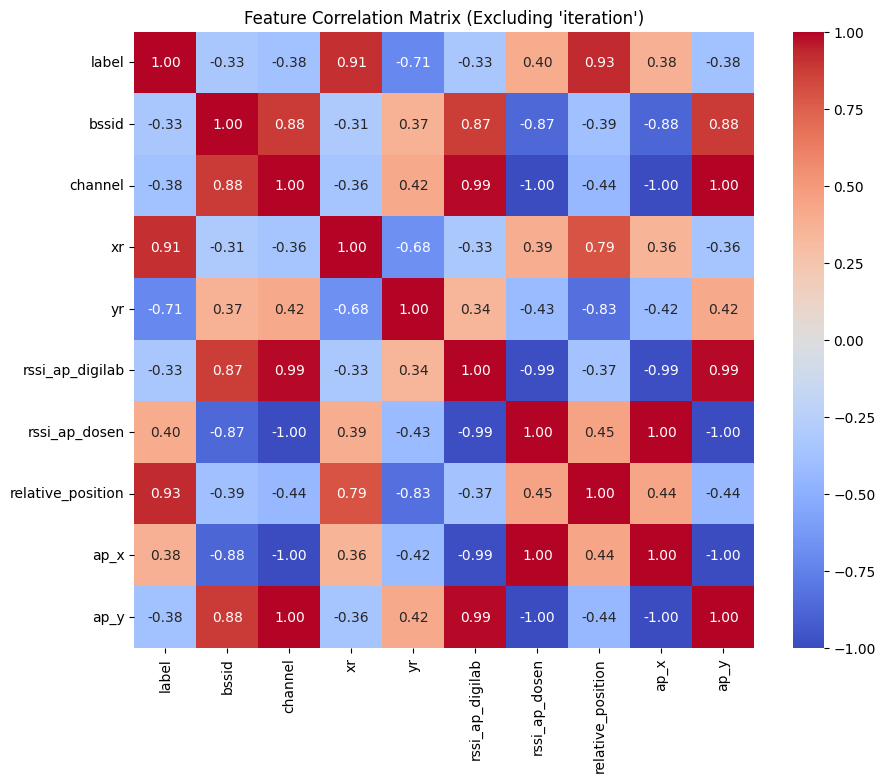

In [279]:
import pandas as pd
import numpy as np

# Drop the 'iteration' column before computing correlation
# df_filtered = df.drop(columns=['iteration', 'obstacle_loss', 'distance'])

# Compute correlation matrix
correlation_matrix = df_filtered.corr(method='pearson')  # Use 'spearman' for rank correlation

# Display the correlation matrix
print(correlation_matrix)

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix (Excluding 'iteration')")
plt.show()

In [280]:
df

,time,label,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp
0,2024-10-17 08:38:31.952562400+00:00,1,3,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:38:31.952562,300
1,2024-10-17 08:39:38.608620600+00:00,1,1,DTE Staff,3,11,300,1368,-63.0,-200.0,0,08:39:38.608620,300
2,2024-10-17 08:39:45.832622300+00:00,1,1,DTE Student,4,11,300,1368,-63.0,-200.0,0,08:39:45.832622,300
3,2024-10-17 08:40:03.157448400+00:00,1,2,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:40:03.157448,300
4,2024-10-17 08:40:08.170180900+00:00,1,2,DTE Staff,3,11,300,1368,-65.0,-200.0,0,08:40:08.170180,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,2024-10-23 09:33:08.645044200+00:00,31,19,DTE Staff,2,1,1219,1037,-200.0,-83.0,1,09:33:08.645044,1219
1940,2024-10-23 09:33:24.612093500+00:00,31,20,DTE Student,4,11,1219,1037,-43.0,-200.0,1,09:33:24.612093,1219
1941,2024-10-23 09:33:27.692327200+00:00,31,20,DTE Staff,3,11,1219,1037,-43.0,-200.0,1,09:33:27.692327,1219
1942,2024-10-23 09:33:30.658762200+00:00,31,20,DTE Staff,1,1,1219,1037,-200.0,-83.0,1,09:33:30.658762,1219


### Are there overlapping points?

In [281]:
# binned_data = df.copy()
# binned_data.iloc[:, :-1] = np.round(binned_data.iloc[:, :-1]) 
# overlapping_points = binned_data.groupby(list(binned_data.columns[:-1]))['label'].nunique()
# overlapping_points = overlapping_points[overlapping_points > 1]
# overlapping_data = binned_data.set_index(list(binned_data.columns[:-1])).loc[overlapping_points.index]

# overlapping_data

In [282]:
# # delete overlapping data 
# non_overlapping_mask = ~binned_data.set_index(list(binned_data.columns[:-1])).index.isin(overlapping_points.index)
# df = df[non_overlapping_mask]
# df.shape

## Regression Model

In [283]:
data.columns.tolist()

['time',
 'reference_point',
 'iteration',
 'ssid',
 'bssid',
 'channel',
 'xr',
 'yr',
 'rssi_ap_digilab',
 'rssi_ap_dosen',
 'relative_position',
 'time_numeric',
 'xp',
 'yp']

In [284]:
# X = data.iloc[:, [0, 1, 2, 3, 4, 5, 8, 10, 11, 12]]
# y = data.iloc[:, [6, 7]]
X = data.iloc[:, [1, 2, 4, 5, 10, 12, 13]]
y = data.iloc[:, [8, 9]]

In [285]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'relative_position', 'xp', 'yp']
Columns in y: ['rssi_ap_digilab', 'rssi_ap_dosen']


## Buat misahin

In [286]:
print(X.head())
print(X.dtypes)

   reference_point  iteration  bssid  channel  relative_position   xp    yp
0                1          3      4       11                  0  300  1368
1                1          1      3       11                  0  300  1368
2                1          1      4       11                  0  300  1368
3                1          2      4       11                  0  300  1368
4                1          2      3       11                  0  300  1368
reference_point      int64
iteration            int64
bssid                int64
channel              int64
relative_position    int64
xp                   int64
yp                   int64
dtype: object


In [287]:
from sklearn.preprocessing import PolynomialFeatures, RobustScaler


class CustomDataset(Dataset):
    def __init__(self, features, labels):
        if isinstance(features, np.ndarray): self.features = torch.tensor(features, dtype=torch.float32)
        else: self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
regression_data_scaled = RobustScaler().fit_transform(X)

dataset = CustomDataset(regression_data_scaled, y)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

dataset = CustomDataset(regression_data_scaled, y)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [288]:
print("\nColumns in X:", X.columns.tolist())
print("Columns in y:", y.columns.tolist())


Columns in X: ['reference_point', 'iteration', 'bssid', 'channel', 'relative_position', 'xp', 'yp']
Columns in y: ['rssi_ap_digilab', 'rssi_ap_dosen']


In [289]:
# # Import necessary libraries
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming X and y are preprocessed and split-ready
# # Ensure y is a numpy array
# y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(regression_data_scaled, y, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

In [290]:
# Import necessary libraries
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Ensure y is a numpy array
y = np.array(y)  # Convert to numpy array if y is a pandas DataFrame or Series

# Step 1: Split the dataset into 70% training, 30% remaining (not final test set)
X_train, X_unused, y_train, y_unused = train_test_split(regression_data_scaled, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=1)

# Step 2: Use 100% of the dataset as the test set
X_test = regression_data_scaled  # Full dataset as test set
y_test = y  # Full dataset labels

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]} (Full Dataset)")

Training set size: 1196
Test set size: 1944 (Full Dataset)


In [291]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
# Use MultiOutputRegressor to handle multiple targets
multi_xgb = MultiOutputRegressor(xgb_model)

In [292]:
# Define hyperparameters for tuning
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [3, 4, 5],
    'estimator__learning_rate': [0.01, 0.1, 0.3]
}

In [293]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(multi_xgb, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=None,
                                                                   booster=None,
                                                                   callbacks=None,
                                                                   colsample_bylevel=None,
                                                                   colsample_bynode=None,
                                                                   colsample_bytree=None,
                                                                   device=None,
                                                                   early_stopping_rounds=None,
                                                                   enable_categorical=False,
                                                                   eval_metric=None,
                                                                   feature_types=None,
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constr...
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=None,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   random_state=42, ...)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.3],
                         'estimator__max_depth': [3, 4, 5],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [294]:
# Print the best parameters
print("Best parameters found by grid search:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_model = grid_search.best_estimator_

# Print all hyperparameters of the best model
print("\nAll hyperparameters of the best model:")
for i, estimator in enumerate(best_model.estimators_):
    print(f"\nEstimator for dimension {i+1} ({'digilab' if i==0 else 'dosen' if i==1 else 'z'}):")
    for param, value in estimator.get_params().items():
        print(f"  {param}: {value}")

Best parameters found by grid search:
estimator__learning_rate: 0.1
estimator__max_depth: 5
estimator__n_estimators: 200

All hyperparameters of the best model:

Estimator for dimension 1 (digilab):
  objective: reg:squarederror
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: None
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.1
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 5
  max_leaves: None
  min_child_weight: None
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: 200
  n_jobs: None
  num_parallel_tree: None
  random_state: 42
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: None
  tree_method: 

In [295]:
# Make predictions
y_pred = best_model.predict(X_test)

## Visualization

In [296]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Calculate error metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error (MSE): 0.9692
Root Mean Squared Error (RMSE): 0.9845
Mean Absolute Error (MAE): 0.4625
R² Score: 0.9997


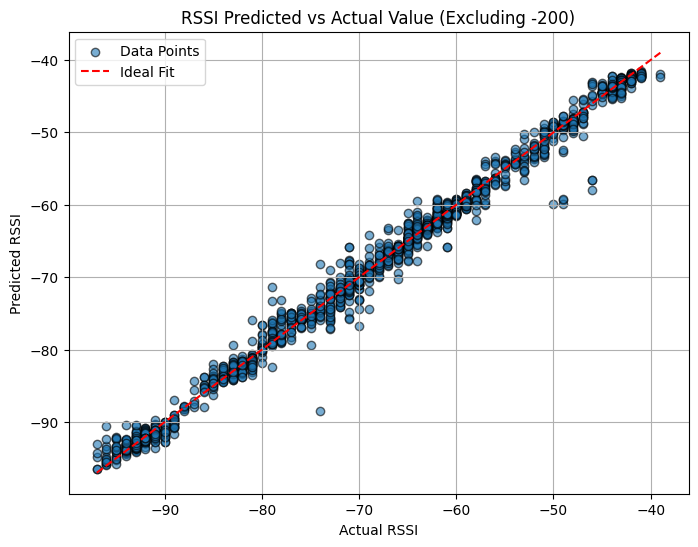

In [297]:
import matplotlib.pyplot as plt
import numpy as np

# Combine RSSI data for Digilab and Dosen into single arrays
combined_actual = np.concatenate([y_test[:, 0], y_test[:, 1]])
combined_predicted = np.concatenate([y_pred[:, 0], y_pred[:, 1]])

# Filter out data points where actual or predicted RSSI equals -200
mask = (combined_actual != -200) & (combined_predicted != -200) & (combined_predicted <= 1)
filtered_actual = combined_actual[mask]
filtered_predicted = combined_predicted[mask]

# Create the scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(filtered_actual, filtered_predicted, alpha=0.6, edgecolors='k', label="Data Points")
plt.plot([filtered_actual.min(), filtered_actual.max()],
         [filtered_actual.min(), filtered_actual.max()], color='red', linestyle='--', label="Ideal Fit")
plt.title("RSSI Predicted vs Actual Value (Excluding -200)")
plt.xlabel("Actual RSSI")
plt.ylabel("Predicted RSSI")
plt.grid(True)
plt.legend()
plt.show()


In [298]:
import pickle

# Save the entire MultiOutputRegressor
with open('rssi_prediction_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("MultiOutputRegressor model saved as 'rssi_prediction_model.pkl'")


MultiOutputRegressor model saved as 'rssi_prediction_model.pkl'


In [299]:
data.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
15,2024-10-17 08:42:30.001785+00:00,1,8,DTE Student,4,11,300,1368,-62.0,-200.0,0,08:42:30.001785,300,1368
1243,2024-10-23 07:11:02.254137800+00:00,42,3,DTE Staff,2,1,2454,1202,-200.0,-71.0,1,07:11:02.254137,2454,1202
499,2024-10-17 10:26:41.654708+00:00,29,18,DTE Staff,3,11,989,1037,-43.0,-200.0,1,10:26:41.654708,989,1037
1894,2024-10-23 09:28:21.002069900+00:00,31,8,DTE Staff,2,1,1219,1037,-200.0,-85.0,1,09:28:21.002069,1219,1037
1549,2024-10-23 08:46:18.151536200+00:00,35,2,DTE Student,4,11,1678,1037,-49.0,-200.0,1,08:46:18.151536,1678,1035


# Genetic Algorithms

In [300]:
# import numpy as np
# import itertools
# import pygad
# import pandas as pd

# # Define the possible transmit power levels for each AP (in dBm)
# ap_digilab_power_levels = [20, 23, 26, 30]
# ap_dosen_power_levels = [20, 23, 26, 30]

# # Genetic Algorithm Parameters
# num_generations = 50  # Number of generations
# num_parents_mating = 4  # Number of parents for crossover
# population_size = (10, 2)  # 10 individuals, each with 2 genes (AP1, AP2 power levels)
# mutation_probability = 0.2  # Probability of mutation

# # Define the fitness function following PyGAD 2.20.0's format
# def fitness_function(ga_instance, solution, solution_idx):
#     digilab_power, dosen_power = solution

#     total_rssi_improvement = 0
#     for _, row in data.iterrows():
#         rssi_digilab = row["rssi_ap_digilab"] + (digilab_power - row["transmit_power"])
#         rssi_dosen = row["rssi_ap_dosen"] + (dosen_power - row["transmit_power"])

#         # Determine which AP provides the best RSSI
#         selected_rssi = max(rssi_digilab, rssi_dosen)
#         total_rssi_improvement += selected_rssi

#     return total_rssi_improvement

# # Initialize the GA
# ga_instance = pygad.GA(
#     num_generations=num_generations,
#     num_parents_mating=num_parents_mating,
#     fitness_func=fitness_function,
#     sol_per_pop=population_size[0],
#     num_genes=population_size[1],
#     gene_space=[ap_digilab_power_levels, ap_dosen_power_levels],
#     mutation_probability=mutation_probability,
#     parent_selection_type="tournament",
#     crossover_type="single_point",
#     mutation_type="random",
#     keep_parents=2,
# )

# # Run the GA
# ga_instance.run()

# # Extract the best solution
# best_solution, best_solution_fitness, _ = ga_instance.best_solution()
# best_digilab_power, best_dosen_power = best_solution

# # Apply the optimized transmit power settings
# results = []
# for _, row in data.iterrows():
#     rssi_digilab_before = row["rssi_ap_digilab"]
#     rssi_dosen_before = row["rssi_ap_dosen"]

#     rssi_digilab_after = rssi_digilab_before + (best_digilab_power - row["transmit_power"])
#     rssi_dosen_after = rssi_dosen_before + (best_dosen_power - row["transmit_power"])

#     selected_rssi_before = max(rssi_digilab_before, rssi_dosen_before)
#     selected_rssi_after = max(rssi_digilab_after, rssi_dosen_after)

#     results.append({
#         "reference_point": row["reference_point"],
#         "iteration": row["iteration"],
#         "rssi_before": selected_rssi_before,
#         "rssi_after": selected_rssi_after,
#         "best_combination": (best_digilab_power, best_dosen_power)
#     })

# # Convert results to DataFrame
# results_df = pd.DataFrame(results)

# # Display the results
# print(results_df.head())  # To preview the top results
# results_df.to_csv("optimized_rssi_results.csv", index=False)  # Save results to CSV

In [301]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Calculate improvement percentage
# results_df["rssi_improvement"] = results_df["rssi_after"] - results_df["rssi_before"]
# results_df["improvement_percentage"] = (results_df["rssi_improvement"] / np.abs(results_df["rssi_before"])) * 100

# # Compute Error Metrics
# def calculate_error_metrics(observed, predicted):
#     observed = np.array(observed)
#     predicted = np.array(predicted)

#     mae = np.mean(np.abs(observed - predicted))
#     mse = np.mean((observed - predicted) ** 2)
#     rmse = np.sqrt(mse)
#     mbe = np.mean(predicted - observed)

#     return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MBE": mbe}

# error_metrics = calculate_error_metrics(results_df["rssi_before"], results_df["rssi_after"])

# # Plot RSSI Before vs. After Optimization
# plt.figure(figsize=(10, 5))
# plt.scatter(results_df["reference_point"], results_df["rssi_before"], label="Before Optimization", alpha=0.6, color='red')
# plt.scatter(results_df["reference_point"], results_df["rssi_after"], label="After Optimization", alpha=0.6, color='green')
# plt.xlabel("Reference Point")
# plt.ylabel("RSSI Value")
# plt.title("RSSI Before vs. After Optimization")
# plt.legend()
# plt.show()

# # Plot Improvement Percentage Distribution
# plt.figure(figsize=(8, 5))
# plt.hist(results_df["improvement_percentage"], bins=30, color='blue', alpha=0.7)
# plt.xlabel("RSSI Improvement Percentage")
# plt.ylabel("Frequency")
# plt.title("Distribution of RSSI Improvement Percentage")
# plt.axvline(results_df["improvement_percentage"].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {results_df['improvement_percentage'].mean():.2f}%")
# plt.legend()
# plt.show()

# # Display Error Metrics
# error_metrics


# Genetic Algorithm 2

In [302]:
import itertools
import pygad
import random

In [303]:
data

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,xp,yp
0,2024-10-17 08:38:31.952562400+00:00,1,3,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:38:31.952562,300,1368
1,2024-10-17 08:39:38.608620600+00:00,1,1,DTE Staff,3,11,300,1368,-63.0,-200.0,0,08:39:38.608620,300,1368
2,2024-10-17 08:39:45.832622300+00:00,1,1,DTE Student,4,11,300,1368,-63.0,-200.0,0,08:39:45.832622,300,1368
3,2024-10-17 08:40:03.157448400+00:00,1,2,DTE Student,4,11,300,1368,-64.0,-200.0,0,08:40:03.157448,300,1368
4,2024-10-17 08:40:08.170180900+00:00,1,2,DTE Staff,3,11,300,1368,-65.0,-200.0,0,08:40:08.170180,300,1368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,2024-10-23 09:33:08.645044200+00:00,31,19,DTE Staff,2,1,1219,1037,-200.0,-83.0,1,09:33:08.645044,1219,1037
1940,2024-10-23 09:33:24.612093500+00:00,31,20,DTE Student,4,11,1219,1037,-43.0,-200.0,1,09:33:24.612093,1219,1037
1941,2024-10-23 09:33:27.692327200+00:00,31,20,DTE Staff,3,11,1219,1037,-43.0,-200.0,1,09:33:27.692327,1219,1037
1942,2024-10-23 09:33:30.658762200+00:00,31,20,DTE Staff,1,1,1219,1037,-200.0,-83.0,1,09:33:30.658762,1219,1037


In [304]:
print("Sample Predicted RSSI Values:", y_pred[:10])

Sample Predicted RSSI Values: [[ -62.707054 -200.01236 ]
 [ -62.898922 -200.02017 ]
 [ -62.954296 -200.02063 ]
 [ -63.974823 -200.01236 ]
 [ -63.899864 -200.0119  ]
 [ -62.707054 -200.01236 ]
 [ -62.63209  -200.0119  ]
 [ -63.141453 -200.02934 ]
 [ -63.216415 -200.0298  ]
 [ -63.12302  -199.97147 ]]


In [305]:
import numpy as np
import pandas as pd
import random

# Define possible transmit power levels for each AP
power_levels = [20, 23, 26, 30]

# Genetic Algorithm Parameters
POPULATION_SIZE = 10
GENERATIONS = 5
MUTATION_RATE = 0.4
CROSSOVER_RATE = 0.7
TOURNAMENT_SIZE = 3  # For selection diversity

# Extract reference points (users) from dataframe
reference_points = data['reference_point'].unique()

# Function to predict RSSI for a given transmit power setting
def predict_rssi_for_power(transmit_power_combination):
    df_temp = data.copy()

    # Assign different transmit power levels to APs
    df_temp['transmit_power_ap_digilab'] = transmit_power_combination[0]
    df_temp['transmit_power_ap_dosen'] = transmit_power_combination[1]

    # Prepare feature set for prediction
    X_test = regression_data_scaled  # Only use valid numeric features
    y_pred = best_model.predict(X_test)  # Predict RSSI for given power

    # Create a DataFrame for predictions
    df_pred = pd.DataFrame(y_pred, columns=['pred_rssi_digilab', 'pred_rssi_dosen'])

    # Attach predictions to the dataframe
    df_temp[['pred_rssi_digilab', 'pred_rssi_dosen']] = df_pred

    return df_temp  # Return updated dataframe with predicted RSSI values

# Function to apply roaming based on predicted RSSI
def apply_roaming(df_temp):
    roaming_users = []
    ROAM_THRESHOLD = 3  # Only roam if new AP is significantly better

    def update_rssi(row):
        # Determine the currently connected AP
        if row['rssi_ap_digilab'] != -200:
            current_ap = 'digilab'
            other_ap = 'dosen'
            current_rssi = row['pred_rssi_digilab']
            other_rssi = row['pred_rssi_dosen']
        else:
            current_ap = 'dosen'
            other_ap = 'digilab'
            current_rssi = row['pred_rssi_dosen']
            other_rssi = row['pred_rssi_digilab']

        # Apply roaming decision
        if other_rssi > current_rssi + ROAM_THRESHOLD:
            row[f'rssi_ap_{current_ap}'] = -200  # Disconnect from previous AP
            row[f'rssi_ap_{other_ap}'] = other_rssi  # Connect to the new AP
            roaming_users.append(row['reference_point'])  # Log roaming event
        else:
            row[f'rssi_ap_{current_ap}'] = current_rssi  # Stay with current AP

        return row

    df_temp = df_temp.apply(update_rssi, axis=1)
    return df_temp, set(roaming_users)  # Return dataframe & roaming users set

# Function to evaluate fitness (Interference Removed)
def evaluate_fitness(transmit_power_combination):
    # Predict RSSI for the current transmit power settings
    df_updated = predict_rssi_for_power(transmit_power_combination)

    # Apply roaming logic
    df_updated, roaming_users = apply_roaming(df_updated)

    total_rssi_before = df[['rssi_ap_digilab', 'rssi_ap_dosen']].replace(-200, np.nan).sum().sum()
    total_rssi_after = df_updated[['rssi_ap_digilab', 'rssi_ap_dosen']].replace(-200, np.nan).sum().sum()

    max_rssi_before = max(df['rssi_ap_digilab'].max(), df['rssi_ap_dosen'].max())
    max_rssi_after = max(df_updated['rssi_ap_digilab'].max(), df_updated['rssi_ap_dosen'].max())

    # Fitness now rewards RSSI improvement
    fitness = (total_rssi_after - total_rssi_before) * 10 + (max_rssi_after - max_rssi_before) * 100

    return fitness, roaming_users, total_rssi_before, total_rssi_after, max_rssi_before, max_rssi_after

# Tournament Selection Function
def tournament_selection(population, fitness_scores, tournament_size=TOURNAMENT_SIZE):
    selected = random.sample(list(zip(fitness_scores, population)), tournament_size)  # Flip order
    selected.sort(key=lambda x: x[0], reverse=True)  # Sort by fitness (higher is better)
    return list(selected[0][1])  # Ensure it returns the selected individual's transmit power settings

# Function to perform crossover
def crossover(parent1, parent2):
    if not isinstance(parent1, list) or not isinstance(parent2, list):
        raise ValueError(f"Crossover Error: Expected lists but got {type(parent1)} and {type(parent2)}")
    
    if random.random() < CROSSOVER_RATE:
        return [parent1[0], parent2[1]], [parent2[0], parent1[1]]  # Swap one power level
    return parent1, parent2


# Function to perform mutation
def mutate(individual):
    if random.random() < MUTATION_RATE:
        mutate_index = random.randint(0, 1)
        individual[mutate_index] = random.choice([p for p in power_levels if p != individual[mutate_index]])
    return individual

# Function to initialize population with diverse power levels
def initialize_population():
    return [random.sample(power_levels, 2) for _ in range(POPULATION_SIZE)]

# Main Genetic Algorithm Loop
population = initialize_population()
best_fitness_history = []

for generation in range(GENERATIONS):
    fitness_scores = []
    
    # Evaluate fitness for each individual
    for individual in population:
        fitness, roaming_users, total_rssi_before, total_rssi_after, max_rssi_before, max_rssi_after = evaluate_fitness(individual)
        fitness_scores.append((fitness, individual, roaming_users, total_rssi_before, total_rssi_after, max_rssi_before, max_rssi_after))

    # Sort population by fitness (descending order)
    fitness_scores.sort(reverse=True, key=lambda x: x[0])
    best_individual = fitness_scores[0][1]
    best_fitness_history.append(fitness_scores[0][0])

    # Print the results
    print(f"\nGeneration {generation + 1}:")
    print(f"Best Transmit Power: {best_individual}")
    print(f"Fitness: {fitness_scores[0][0]}")
    print(f"Roaming Users: {len(fitness_scores[0][2])}, Reference Points That Roamed: {fitness_scores[0][2]}")
    print(f"Total RSSI Before: {fitness_scores[0][3]:.2f}, After: {fitness_scores[0][4]:.2f}")
    print(f"Max RSSI Before: {fitness_scores[0][5]:.2f}, After: {fitness_scores[0][6]:.2f}")

    # Selection using tournament selection instead of always keeping the best
    new_population = [tournament_selection(population, [x[0] for x in fitness_scores]) for _ in range(POPULATION_SIZE//2)]


    # Crossover & Mutation to generate new individuals
    while len(new_population) < POPULATION_SIZE:
        parent1, parent2 = random.sample(new_population, 2)
        child1, child2 = crossover(parent1, parent2)
        new_population.append(mutate(child1))
        new_population.append(mutate(child2))

    # Update population
    population = new_population

# Best transmit power combination after all generations
print(f"\nOptimal Transmit Power: {best_individual}")



Generation 1:
Best Transmit Power: [30, 23]
Fitness: -1768.3509063720703
Roaming Users: 0, Reference Points That Roamed: set()
Total RSSI Before: -131039.00, After: -131190.83
Max RSSI Before: -39.00, After: -41.50

Generation 2:
Best Transmit Power: [26, 23]
Fitness: -1768.3509063720703
Roaming Users: 0, Reference Points That Roamed: set()
Total RSSI Before: -131039.00, After: -131190.83
Max RSSI Before: -39.00, After: -41.50

Generation 3:
Best Transmit Power: [30, 20]
Fitness: -1768.3509063720703
Roaming Users: 0, Reference Points That Roamed: set()
Total RSSI Before: -131039.00, After: -131190.83
Max RSSI Before: -39.00, After: -41.50

Generation 4:
Best Transmit Power: [30, 23]
Fitness: -1768.3509063720703
Roaming Users: 0, Reference Points That Roamed: set()
Total RSSI Before: -131039.00, After: -131190.83
Max RSSI Before: -39.00, After: -41.50

Generation 5:
Best Transmit Power: [26, 20]
Fitness: -1768.3509063720703
Roaming Users: 0, Reference Points That Roamed: set()
Total RS